# Part 1 - Introduction
For this lab demonstration, we will use a dataset from a small credit extension program at a bank. The data contains a random sample of 1,000 transactions including customers' details and the resulting profit for the bank. The bank wants to predict whether a credit extension requested by a customer will be profitable for them or not. 

We will first use a classification tree to classify the records as profitable or not, before applying regression trees to predict the profit directly. 

The objectives of this demonstration is to show how to: 
- Implement decision trees in Python
- Prune the tree using the *ccp_alpha* parameter
- Prune the tree using the *max_depth* parameter 
- Implement regression trees

Now let us look at some of the variables present in the dataset. 

## Data description
- *age*: the age of the customer in years
- *gender*: the gender of the customer
- *duration*: the duration in months for which the customer has been with the bank
- *housing*: a categorical variable that captures the kind of house that the customer lives in
- *amount*: the amount of money in dollars a customer has in their account
- *profit*: the amount of profit in dollars that the bank has earned from this employee

The dataset has numerous other features as well. Note that to perform classification, we need to use the *profit* variable to create another variable called *is_profitable* which will be used as the target varible in the classification problem.

In [22]:
# Import 'numpy' and 'pandas' to work with numbers and dataframes
import pandas as pd
import numpy as np

# Import 'matplotlib.pyplot' for visualizations
from matplotlib import pyplot as plt

# Import method for train-validation split
from sklearn.model_selection import train_test_split

# Import methods for building and visualizing decision trees
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree

# Import 'GridSearchCV' for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Import suitable performance metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, mean_squared_error, roc_auc_score

In [2]:
# Load and view the data
credit_df = pd.read_csv('MyCreditData.csv')
credit_df.head()

,checking_account,duration,credit_history,purpose,amount,savings_account,employment_duration,installment_rate,other_debtors,present_residence,...,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,gender,profit
0,3,18,0,2,1049,4,2,2,2,3,...,21,1,0,0,1,0,0,0,female,242
1,3,9,0,5,2799,4,0,1,2,0,...,36,1,0,1,1,1,0,0,male,596
2,0,12,4,8,841,0,1,1,2,3,...,23,1,0,0,3,0,0,0,female,25
3,3,12,0,5,2122,4,0,0,2,0,...,39,1,0,1,3,1,0,1,male,568
4,3,12,0,5,2171,4,0,2,2,3,...,38,0,2,1,3,0,0,1,male,782


In [3]:
# Ensure Python reads the categorical variables as categorical
non_categorical_columns = ['duration', 'amount', 'age', 'profit']

for column in credit_df.columns:
    if column not in non_categorical_columns:
        credit_df[column] = pd.Categorical(credit_df[column])

# Create binary dependent variable 'is_profitable' using the 'profit' feature for the purpose of classification
credit_df['is_profitable'] = np.where(credit_df['profit'] > 0, 1, 0)

Note that standardization of variables is not necessary for trees. So, we proceed to splitting the data into input/output and training/validation sets.

In [4]:
# Split data into input variables and target variable
y = credit_df['is_profitable']
X = credit_df.iloc[:, :-2] # All columns but the last two, profit and is_profitable

# Use dummy variables for categorical variables
X = pd.get_dummies(X, drop_first = False)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [5]:
# View the input data
X.head()

,duration,amount,age,checking_account_0,checking_account_1,checking_account_2,checking_account_3,credit_history_0,credit_history_1,credit_history_2,...,job_3,people_liable_0,people_liable_1,telephone_0,telephone_1,foreign_worker_0,foreign_worker_1,gender_female,gender_male,gender_nonbinary/notreported
0,18,1049,21,False,False,False,True,True,False,False,...,False,True,False,True,False,True,False,True,False,False
1,9,2799,36,False,False,False,True,True,False,False,...,False,False,True,True,False,True,False,False,True,False
2,12,841,23,True,False,False,False,False,False,False,...,True,True,False,True,False,True,False,True,False,False
3,12,2122,39,False,False,False,True,True,False,False,...,True,False,True,True,False,False,True,False,True,False
4,12,2171,38,False,False,False,True,True,False,False,...,True,True,False,True,False,False,True,False,True,False


# Part 2 - Classification using decision trees
Our goal is to classify *is_profitable* using all available information, using a classification tree.

In [6]:
# Train a decision tree using the training dataset
tree_clf = DecisionTreeClassifier(random_state = 0, max_depth = 20)
tree_clf = tree_clf.fit(X_train, y_train)

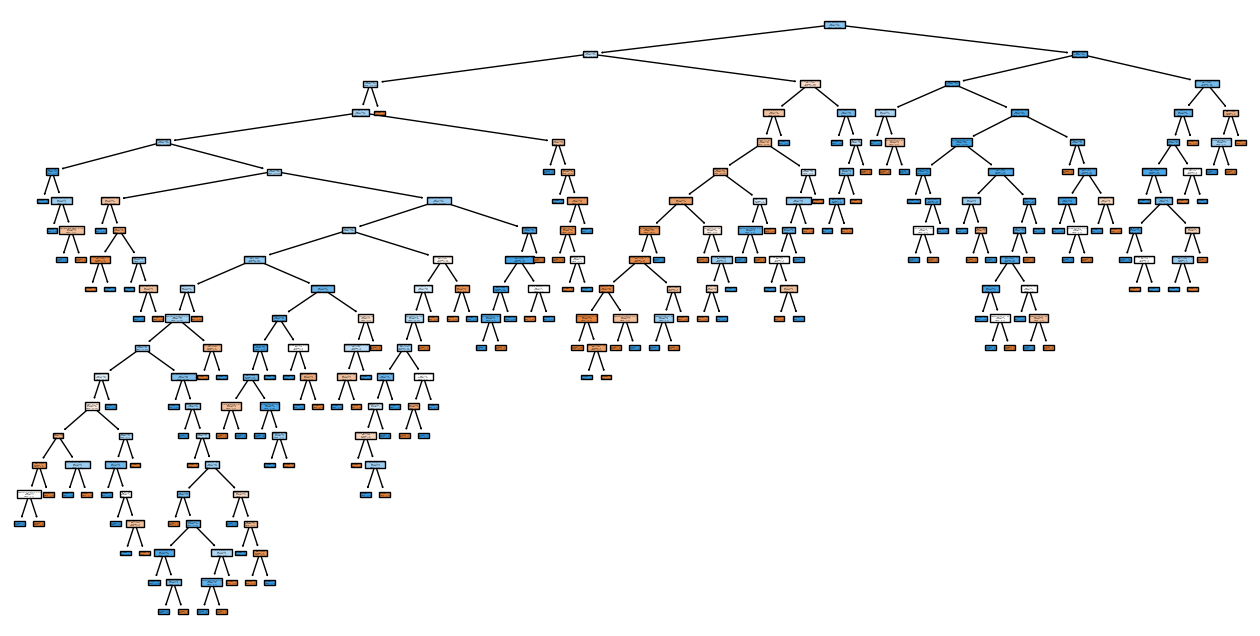

In [7]:
# Visualize the decision tree
# Note: You can view plotting options and other documentation for 'tree.plot_tree()' at sklearn's webpage
# Link - https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
fig = plt.figure(figsize = (16, 8))
fig = tree.plot_tree(tree_clf, feature_names = X.columns, filled = True)

In [8]:
# Print the number of leaves and the depth of the tree
print('Number of leaves =', tree_clf.get_n_leaves())
print('Tree depth =', tree_clf.get_depth())

Number of leaves = 141
Tree depth = 20


The number of leaves and the depth of the tree is quite high. Actually, this tree is overfit on purpose! Let's confirm this by looking at the confusion matrices and by comparing the accuracy of the tree for both the training and validaiton data.

In [9]:
# Perform prediction on the training and validation datasets
y_train_pred = tree_clf.predict(X_train)
y_val_pred = tree_clf.predict(X_val)

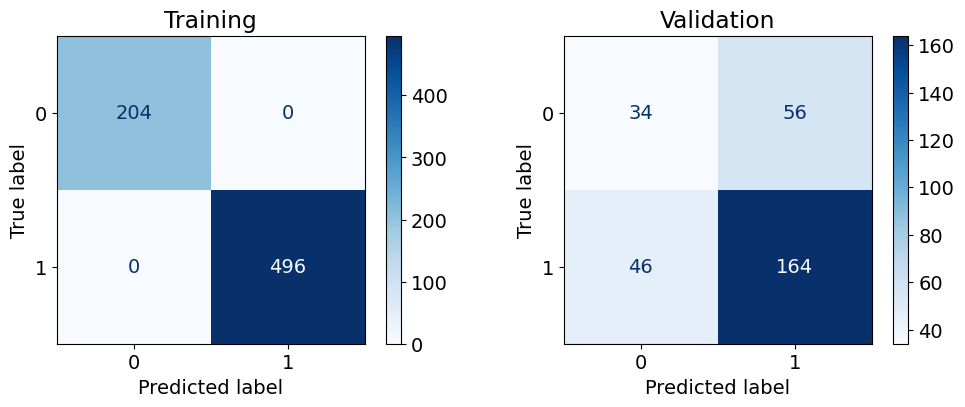

In [10]:
plt.rcParams.update({'font.size': 14}) # To make the plot labels easier to read

# Print the confusion matrices for the training and validation data
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ConfusionMatrixDisplay.from_estimator(tree_clf, X_train, y_train, cmap = plt.cm.Blues, ax = ax[0])
ConfusionMatrixDisplay.from_estimator(tree_clf, X_val, y_val, cmap = plt.cm.Blues, ax = ax[1])
ax[0].set_title('Training')
ax[1].set_title('Validation');

In [11]:
# Print the accuracy scores
print(f'Accuracy score on the training dataset: {round(accuracy_score(y_train_pred, y_train), 3)}')
print(f'Accuracy score on the validation dataset: {round(accuracy_score(y_val_pred, y_val), 3)}')

Accuracy score on the training dataset: 1.0
Accuracy score on the validation dataset: 0.66


The accuracy score is much higher on the training dataset than on the validation dataset. That is, the model performs much better on the training dataset than on the validation dataset, confirming that the model is overfitting. 


# Part 3 - Pruning the tree using cost complexity

To reduce overfitting, we need to prune our tree. There are a number of different ways in which we can implement this in Python. The one that we present here follows the CART algorithm quite closley. 

We do this using a complexity parameter called *ccp_alpha*, in the *DecisionTreeClassifier()* method. By varying the value of *ccp_alpha* we get a range of trees of different complexity. Smaller values of *ccp_alpha* result in larger trees, while larger values of *ccp_alpha* result in smaller trees. 

What is happening behind the scenes is that, higher values of the complexity parameter raise the threshold for introducing a split, based on the contribution of the split to lowering misclassification rates . More info available [here](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning).

The *DecisionTreeClassifier()* method in *scikit-learn* has an algorithm called *cost_complexity_pruning_path()* which finds all candidates for *ccp_alpha*. We then test each *ccp_alpha* value to test how well the resulting tree does on the validation data, finding an optimal value for the complexity parameter *ccp_alpha*, and the minimum error tree! 

In [12]:
# Calculate and print the values of alpha
path = tree_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00094424 0.00125    0.0012987  0.00130952 0.00134199
 0.00134921 0.00136364 0.00137143 0.00142857 0.00142857 0.00142857
 0.0015873  0.00163265 0.00163265 0.00164777 0.001671   0.00171429
 0.00177706 0.00178932 0.00181818 0.00186688 0.00190476 0.00190476
 0.00195918 0.00210419 0.00214286 0.00214286 0.00217687 0.00218254
 0.00222222 0.00228445 0.00230159 0.00238095 0.00238095 0.00244716
 0.0024531  0.0025     0.0025     0.00261615 0.00269255 0.00269841
 0.00285714 0.00319529 0.00323676 0.00324675 0.00330834 0.00333791
 0.0033758  0.00341849 0.0034211  0.00342132 0.00343543 0.00348239
 0.00367118 0.00409281 0.00420075 0.00442285 0.00480159 0.00520552
 0.00583696 0.00740969 0.00763798 0.00809014 0.01117928 0.0436274 ]


In [13]:
# We will create a decision tree model for each alpha and store the models in a list
clfs = []

for ccp_alpha in ccp_alphas:

    # Train a model with a value from the list of ccp_alphas
    curr_clf = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    curr_clf.fit(X_train, y_train)

    # Add the model to the list of models
    clfs.append(curr_clf)

Detour: We will now plot a graph to show how the number of nodes of the trees and their depths vary as the cost complexity increases.

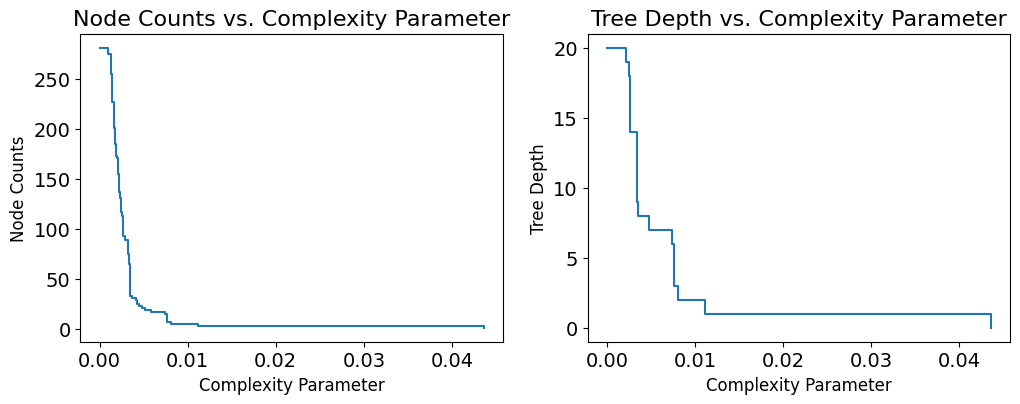

In [14]:
# Obtain the number of nodes and tree depths for the trees from our list
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

# Create the plots
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(ccp_alphas, node_counts, label = 'no of nodes', drawstyle = "steps-post")
ax[0].set_xlabel('Complexity Parameter', fontsize = 12)
ax[0].set_ylabel('Node Counts', fontsize = 12)
ax[0].set_title('Node Counts vs. Complexity Parameter', fontsize = 16)
ax[1].plot(ccp_alphas, depth, label = 'depth', drawstyle = "steps-post")
ax[1].set_xlabel('Complexity Parameter', fontsize = 12)
ax[1].set_ylabel('Tree Depth', fontsize = 12)
ax[1].set_title('Tree Depth vs. Complexity Parameter', fontsize = 16);

As you can see the number of nodes and the depth of the trees go down as the cost complexity increases. Now we plot the training and validation accuracy for the different values of the complexity parameter.

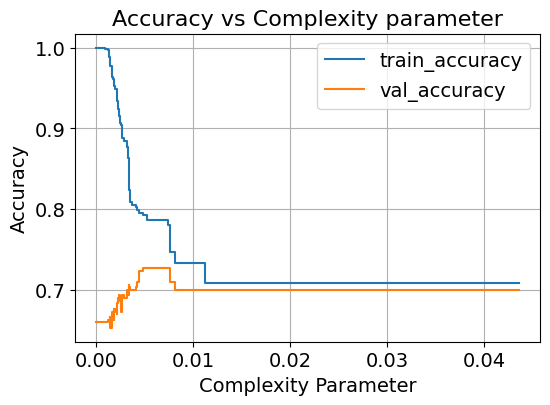

In [15]:
# Create an empty list to store the accuracy values for the training and validation datasets
train_acc = []
val_acc = []

# Iterate over the list of models
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_val_pred = c.predict(X_val)

    # Append the accuracy values for the training and validation datasets to our lists
    train_acc.append(accuracy_score(y_train_pred, y_train))
    val_acc.append(accuracy_score(y_val_pred, y_val))

# Plot a graph to show how the training and validation accuracies vary as the complexity parameter increases
plt.figure(figsize = (6, 4))
plt.plot(ccp_alphas, train_acc, label = 'train_accuracy', drawstyle = "steps-post")
plt.plot(ccp_alphas, val_acc, label = 'val_accuracy', drawstyle = "steps-post")
plt.legend()
plt.title('Accuracy vs Complexity parameter', fontsize = 16)
plt.xlabel('Complexity Parameter')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

We take the tree with the highest validation accuracy for our final model and visualize the tree.

In [16]:
# Find the value of ccp_alpha for which the validation accuracy is the highest
best_ccp_alpha = ccp_alphas[val_acc.index(max(val_acc))]
print('Best CCP alpha: ', best_ccp_alpha)

# Train a Decision tree with the best ccp_alpha value
best_tree_clf = tree.DecisionTreeClassifier(random_state = 0, ccp_alpha = best_ccp_alpha)
best_tree_clf.fit(X_train, y_train)

# Visualize the decision tree
fig = plt.figure(figsize = (16, 12))
fig = tree.plot_tree(best_tree_clf, feature_names = X.columns, filled = True, label = None)

Best CCP alpha:  0.004801587301587302


InvalidParameterError: The 'label' parameter of plot_tree must be a str among {'all', 'none', 'root'}. Got None instead.

<Figure size 1600x1200 with 0 Axes>

In [ ]:
# Print the number of leaves and the depth of the tree
print('Number of leaves =', best_tree_clf.get_n_leaves())
print('Tree depth =', best_tree_clf.get_depth())

Note that the number of leaves and the tree depth have now reduced. We will also output its confusion matrix for the training and the validation datasets, its accuracy on the two datasets, and various other performance measures.

In [ ]:
# Perform prediction on the training and validation datasets
y_train_pred = best_tree_clf.predict(X_train)
y_val_pred = best_tree_clf.predict(X_val)

In [ ]:
plt.rcParams.update({'font.size': 14}) # To make the plot labels easier to read

# Print the confusion matrices for the training and validation data
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ConfusionMatrixDisplay.from_estimator(best_tree_clf, X_train, y_train, cmap = plt.cm.Blues, ax = ax[0])
ConfusionMatrixDisplay.from_estimator(best_tree_clf, X_val, y_val, cmap = plt.cm.Blues, ax = ax[1])
ax[0].set_title('Training')
ax[1].set_title('Validation');

In [ ]:
# Print the accuracy scores
print(f'Accuracy score on the training dataset: {round(accuracy_score(y_train_pred, y_train), 3)}')
print(f'Accuracy score on the validation dataset: {round(accuracy_score(y_val_pred, y_val), 3)}')

In [ ]:
# Print the other performance measures
print('Performance measures on the validation set\n')
print('Accuracy Score: %.3f' % accuracy_score(y_val, y_val_pred))
print('F1 Score: %.3f' % f1_score(y_val, y_val_pred))
print('Sensitivity (recall of positive class): %.3f' % recall_score(y_val, y_val_pred, pos_label = 1))
print('Specificty (recall of negative class): %.3f' % recall_score(y_val, y_val_pred, pos_label = 0))

# Part 4 - Pruning the tree using the maximum tree depth

Alternatively we can prune back the tree using max_depth (or any other parameter). Note that we are no longer using the validaiton data, rather we are relying on cross-validaiton to evaluate the models' performance. 

While simpler to code (a plus) the results are often not as good. 

We will implement this approach using the *GridSearchCV()* method, varying the *max_depth* parameter.

In [ ]:
# Create a DecisionTreeClassifier object
tree_clf = DecisionTreeClassifier(random_state = 0)

# Define the range of the max_depth parameter
param_grid = {'max_depth': np.arange(2, 26)} # Parameter range

# Perform grid search
grid = GridSearchCV(tree_clf, param_grid, cv = 5, scoring = 'accuracy', return_train_score = False, verbose = 1)
grid_search = grid.fit(X_train, y_train)

# Print the optimal value of max_depth
print('The optimal value of max_depth is', grid_search.best_params_['max_depth'])

Using this optimal *max_depth*, we train a new tree.

In [ ]:
# Train a tree using the optimal max_depth
best_tree_clf = DecisionTreeClassifier(random_state = 0, max_depth = grid_search.best_params_['max_depth'])
best_tree_clf = best_tree_clf.fit(X_train, y_train)

# Visualize the decision tree
fig = plt.figure(figsize = (16, 8))
fig = tree.plot_tree(best_tree_clf, feature_names = X.columns, filled = True, label = None)

In [ ]:
# Print the number of leaves and the depth of the tree
print('Number of leaves =', best_tree_clf.get_n_leaves())
print('Tree depth =', best_tree_clf.get_depth())

We will also output its confusion matrix for the training and the validation datasets, its accuracy on the two datasets, and various other performance measures.

In [ ]:
# Perform prediction on the training and validation datasets
y_train_pred = best_tree_clf.predict(X_train)
y_val_pred = best_tree_clf.predict(X_val)

In [ ]:
plt.rcParams.update({'font.size': 14}) # To make the plot labels easier to read

# Print the confusion matrices for the training and validation data
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ConfusionMatrixDisplay.from_estimator(best_tree_clf, X_train, y_train, cmap = plt.cm.Blues, ax = ax[0])
ConfusionMatrixDisplay.from_estimator(best_tree_clf, X_val, y_val, cmap = plt.cm.Blues, ax = ax[1])
ax[0].set_title('Training')
ax[1].set_title('Validation');

In [ ]:
# Print the accuracy scores
print(f'Accuracy score on the training dataset: {round(accuracy_score(y_train_pred, y_train), 3)}')
print(f'Accuracy score on the validation dataset: {round(accuracy_score(y_val_pred, y_val), 3)}')

In [ ]:
# Print the other performance measures
print('Performance measures on the validation set\n')
print('Accuracy Score: %.3f' % accuracy_score(y_val, y_val_pred))
print('F1 Score: %.3f' % f1_score(y_val, y_val_pred))
print('Sensitivity (recall of positive class): %.3f' % recall_score(y_val, y_val_pred, pos_label = 1))
print('Specificty (recall of negative class): %.3f' % recall_score(y_val, y_val_pred, pos_label = 0))

# Part 5 - Regression Trees

Now lets run a regression tree. First, we reset *y* to be profit.

In [ ]:
# Use 'profit' instead of 'is_profitable' as the dependent variable
y = credit_df['profit']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 1)

Now, we build the regression tree model.

In [ ]:
# Train the regression tree
tree_reg = DecisionTreeRegressor(random_state = 0, max_depth=3)
tree_reg = tree_reg.fit(X_train, y_train)

# Visualize the regression tree
fig = plt.figure(figsize = (16, 8))
fig = tree.plot_tree(tree_reg, feature_names = X.columns, filled = True, label = None)

Lets find the optimal tree by pruning back the regression tree using the cost-complexity trade-off

In [ ]:
# Calculate and print the values of alpha
path = tree_reg.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

# We will create a regression tree model for each alpha and store the models in a list
regs = []

for ccp_alpha in ccp_alphas:

    # Train a model with a value from the list of ccp_alphas
    curr_reg = DecisionTreeRegressor(random_state = 0, ccp_alpha = ccp_alpha)
    curr_reg.fit(X_train, y_train)

    # Add the model to the list of models
    regs.append(curr_reg)

Let's measure its performance by calculating the root mean squared error (RMSE). 

In [ ]:
# Define function to calculate RMSE
def rmse(y_train, y_pred):
    return np.sqrt(mean_squared_error(y_train, y_pred))

In [ ]:
# Create an empty list to store the accuracy values for the training and validation datasets
train_rmse = []
val_rmse = []

# Iterate over the list of models
for r in regs:
    y_train_pred = r.predict(X_train)
    y_val_pred = r.predict(X_val)

    # Append the accuracy values for the training and validation datasets to our lists
    train_rmse.append(rmse(y_train_pred, y_train))
    val_rmse.append(rmse(y_val_pred, y_val))

# Plot a graph to show how the training and validation accuracies vary as the complexity parameter increases
plt.figure(figsize = (6, 4))
plt.plot(ccp_alphas, train_rmse, label = 'train', drawstyle = "steps-post")
plt.plot(ccp_alphas, val_rmse, label = 'val', drawstyle = "steps-post")
plt.legend()
plt.title('RMSE vs Complexity parameter', fontsize = 16)
plt.xlabel('Complexity Parameter')
plt.ylabel('RMSE')
plt.grid()
plt.show()

In [ ]:
# Find the value of ccp_alpha for which the validation rmse is the lowest
best_ccp_alpha = ccp_alphas[val_rmse.index(min(val_rmse))]
print('Best CCP alpha: ', best_ccp_alpha)

# Train a Decision tree with the best ccp_alpha value
best_tree_reg = tree.DecisionTreeRegressor(random_state = 0, ccp_alpha = best_ccp_alpha)
best_tree_reg.fit(X_train, y_train)

# Visualize the decision tree
fig = plt.figure(figsize = (8, 4))
fig = tree.plot_tree(best_tree_reg, feature_names = X.columns, filled = True, label = None)

In [ ]:
# Calculate RMSE on the training and validation sets
y_train_pred = best_tree_reg.predict(X_train)
y_val_pred = best_tree_reg.predict(X_val)
print('RMSE on the training set:', round(rmse(y_train, tree_reg.predict(X_train)), 3))
print('RMSE on the validation set:', round(rmse(y_val, tree_reg.predict(X_val)), 3))

In [23]:
?roc_curve

Signature:
roc_curve(
    y_true,
    y_score,
    *,
    pos_label=None,
    sample_weight=None,
    drop_intermediate=True,
)
Docstring:
Compute Receiver operating characteristic (ROC).

Note: this implementation is restricted to the binary classification task.

Read more in the :ref:`User Guide <roc_metrics>`.

Parameters
----------
y_true : array-like of shape (n_samples,)
    True binary labels. If labels are not either {-1, 1} or {0, 1}, then
    pos_label should be explicitly given.

y_score : array-like of shape (n_samples,)
    Target scores, can either be probability estimates of the positive
    class, confidence values, or non-thresholded measure of decisions
    (as returned by "decision_function" on some classifiers).

pos_label : int, float, bool or str, default=None
    The label of the positive class.
    When ``pos_label=None``, if `y_true` is in {-1, 1} or {0, 1},
    ``pos_label`` is set to 1, otherwise an error will be raised.

sample_weight : array-like of shape (